In [2]:
# Cellule 1 : Importations et configuration de l'environnement
import os
import json
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Pour le découpage de texte et la gestion des documents
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Pour les embeddings (deux modèles)
from langchain_huggingface import HuggingFaceEmbeddings

# Pour l'appel aux LLM (ici, on simule des appels vers une instance locale OpenAI-like)
from langchain_openai import ChatOpenAI
import tiktoken

# Pour la tokenisation (debug)
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Configuration (exemple d'API et variables d'environnement)
os.environ["OPENAI_API_KEY"] = "votre_cle_api"  # Remplacez par votre clé

# Initialisation du client LLM (ici on simule un client local)
client = ChatOpenAI(model_name="mistral-7b-instruct-v0.3", temperature=0.1)

# Affichage d'information
print("Environnement et dépendances chargés.")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\20200337\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\20200337\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Environnement et dépendances chargés.


## Cellule 2 : Chargement et Prétraitement des Données

- Nous chargeons les documents depuis le fichier JSONL.
- Nous n'utiliserons que le champ `content` (et les métadonnées associées, comme l'URL).
- Chaque document est converti en objet `Document`.


In [3]:
# Cellule 3 : Chargement des données et création des Documents

# Chemin vers le fichier merged (contenant le champ "content")
merged_path = "DATA"+ "/"+ "01_documents_merged.jsonl"
df_merged = pd.read_json(merged_path, lines=True)
print(f"Documents chargés : {df_merged.shape}")

# Conversion de chaque ligne en Document (on utilise uniquement 'content' et 'url' depuis metadata)
def row_to_document(row):
    return Document(
        page_content=row["content"],
        metadata={"url": row["url"]}
    )

documents = df_merged.apply(row_to_document, axis=1).tolist()
print(f"Total de documents créés : {len(documents)}")
print("Exemple de document :", documents[0].metadata, "\nContenu (tronqué) :", documents[0].page_content[:200])


Documents chargés : (224, 4)
Total de documents créés : 224
Exemple de document : {'url': 'https://www.uqac.ca/mgestion/chapitre-4/reglement-relatif-aux-ressources-humaines/politique-relative-a-lengagement-du-personnel-des-categories-professionnel-technique-bureau-metiers-et-services-de-luqac/'} 
Contenu (tronqué) : Adoption
Instance
Date
Décision
Conseil d’administration
27 avril 1982
CAD-2980
Modification
Instance
Date
Décision
Commentaires
Révision
À tous les cinq (5) ans
Responsable
Le vice-recteur ou la vice


## Cellule 4 : Découpage des Documents en Chunks

Nous utilisons `RecursiveCharacterTextSplitter` pour découper les contenus en chunks avec chevauchement.


In [4]:
# Cellule 4 : Découpage en chunks
chunk_size = 750
chunk_overlap = 300

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
    length_function=len,
    add_start_index=True
)

chunks = text_splitter.split_documents(documents)
print(f"Nombre de chunks créés : {len(chunks)}")

Nombre de chunks créés : 4315


## Cellule 5 : Vectorisation des Chunks avec Deux Modèles d'Embeddings

- **Modèle Global :** `intfloat/multilingual-e5-base`
- **Modèle Spécialisé Français :** `almanach/camembert-base`
  
Chaque chunk est vectorisé avec les deux modèles.


In [5]:
# Cellule 5 : Vectorisation des chunks
embeddings_model = HuggingFaceEmbeddings(model_name="intfloat/multilingual-e5-base")
french_specialised_embedding_model = HuggingFaceEmbeddings(model_name="almanach/camembert-base")


No sentence-transformers model found with name almanach/camembert-base. Creating a new one with MEAN pooling.


In [6]:

chunk_data = []
print("Calcul des embeddings pour chaque chunk ...")
for chunk in tqdm(chunks, desc="Embedding des chunks"):
    emb_global = embeddings_model.embed_query(chunk.page_content)
    emb_french = french_specialised_embedding_model.embed_query(chunk.page_content)
    chunk_data.append({
        "content": chunk.page_content,
        "metadata": chunk.metadata,
        "global_embedding": emb_global,
        "french_embedding": emb_french
    })

# Conversion en DataFrame pour faciliter l'analyse
df_chunks = pd.DataFrame(chunk_data)
print("DataFrame des chunks :", df_chunks.shape)

# Sauvegarde optionnelle pour debug
# df_chunks.to_json("DB/CHUNKS_VECTORISES.jsonl", orient='records', lines=True)


Calcul des embeddings pour chaque chunk ...


Embedding des chunks:   0%|          | 0/4315 [00:00<?, ?it/s]

DataFrame des chunks : (4315, 4)


## Cellule 6 : Analyse des Similarités entre Embeddings

Nous comparons, pour un même chunk, la similarité cosinus entre les deux embeddings.


Similarité moyenne entre les deux modèles sur les chunks : 0.0378


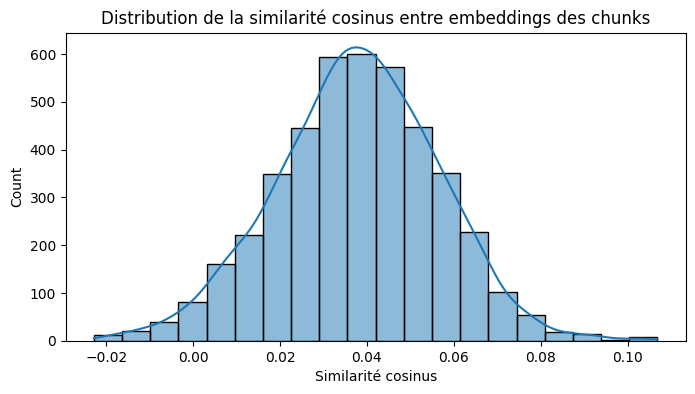

In [7]:
# Cellule 6 : Calcul et affichage des similarités entre les embeddings pour chaque chunk
from sklearn.metrics.pairwise import cosine_similarity

def cosine_similarity_between(emb1, emb2):
    return cosine_similarity([emb1], [emb2])[0][0]

similarities = []
for i in range(len(df_chunks)):
    sim = cosine_similarity_between(df_chunks.iloc[i]["global_embedding"], df_chunks.iloc[i]["french_embedding"])
    similarities.append(sim)

df_chunks["similarity_between_models"] = similarities
print("Similarité moyenne entre les deux modèles sur les chunks : {:.4f}".format(np.mean(similarities)))

# Visualisation de la distribution des similarités
plt.figure(figsize=(8, 4))
sns.histplot(similarities, bins=20, kde=True)
plt.title("Distribution de la similarité cosinus entre embeddings des chunks")
plt.xlabel("Similarité cosinus")
plt.show()


## Cellule 7 : Génération de Variations Synonymiques pour la Question

Ici, nous définissons une fonction qui, pour une question donnée, génère des variations (sans abstraction, uniquement des synonymes ou reformulations) en utilisant un appel à l'API LLM.


In [8]:
from openai import OpenAI  # The Deepseek R1 client uses a similar interface
client = OpenAI(
    api_key="none",  # Not used for local inference
    base_url="http://127.0.0.1:1234/v1"
)

In [9]:
# Cellule 7 : Génération de variations de la question

def generate_question_variations(question, num_variations=3, model_name= "mistral-7b-instruct-v0.3"):
    """
    Génère des variations synonymiques pour une question donnée.
    La fonction utilise un prompt explicite et appelle le LLM.
    """
    prompt = (
        "Voici une question :\n"
        f"\"{question}\"\n"
        "Génère " + str(num_variations) + " variations de cette question en utilisant des synonymes, "
        "sans changer le sens, uniquement en reformulant la question. "
        "Retourne la réponse au format JSON, par exemple :\n"
        '{"variations": ["Variation 1", "Variation 2", "Variation 3"]}'
    )
    
    response = client.chat.completions.create(
        model=model_name,
        messages=[{"role": "user", "content": prompt}],
        temperature=0.1,
    )
    
    raw_output = response.choices[0].message.content
    print("Réponse brute pour variations de question :\n", raw_output)
    
    try:
        result = json.loads(raw_output)
        return result.get("variations", [])
    except json.JSONDecodeError:
        print("Erreur de décodage JSON, utilisation d'une solution de secours.")
        # En cas d'erreur, on retourne une simple liste contenant la question d'origine
        return [question]


---

In [79]:
initial_question = "Qui sont les responsables de l’application des politiques de l'UQAC ?"
initial_question = "Comment peut-on congédier (renvoyer, virer) quelqu'un à l'UQAC ? Quels sont les causes qu'il faut respecter ?"
initial_question = "Comment les incidents en laboratoire/atelier sont-ils signalés et traités ?"
initial_question

'Comment les incidents en laboratoire/atelier sont-ils signalés et traités ?'

In [80]:
# Exemple d'utilisation
variations = generate_question_variations(initial_question, 5)

Réponse brute pour variations de question :
  {
  "variations": [
    "Comment sont signalés et traités les incidents dans le laboratoire/atelier ?",
    "Comment sont gérés les événements anormaux dans le laboratoire/atelier ?",
    "Quel est le processus de signalement et de traitement des incidents dans le laboratoire/atelier ?",
    "Comment les incidents survenant dans le laboratoire/atelier sont-ils gérés ?",
    "Comment sont traités les problèmes qui se produisent dans le laboratoire/atelier ?"
  ]
}


In [81]:

# Toujours ajouter la question initiale à la liste
questions_variations = [initial_question] + variations
print("Questions utilisées :", questions_variations)


Questions utilisées : ['Comment les incidents en laboratoire/atelier sont-ils signalés et traités ?', 'Comment sont signalés et traités les incidents dans le laboratoire/atelier ?', 'Comment sont gérés les événements anormaux dans le laboratoire/atelier ?', 'Quel est le processus de signalement et de traitement des incidents dans le laboratoire/atelier ?', 'Comment les incidents survenant dans le laboratoire/atelier sont-ils gérés ?', 'Comment sont traités les problèmes qui se produisent dans le laboratoire/atelier ?']


## Cellule 8 : Vectorisation des Questions avec les Deux Modèles

Pour chaque question (initiale + variations), nous générons les embeddings avec les deux modèles.


In [82]:
# Cellule 8 : Vectorisation des questions
embedding_questions = []
for q in questions_variations:
    emb_global = embeddings_model.embed_query(q)
    emb_french = french_specialised_embedding_model.embed_query(q)
    embedding_questions.append({
        "question": q,
        "global_embedding": emb_global,
        "french_embedding": emb_french
    })

print(f"Nombre de questions vectorisées : {len(embedding_questions)}")


Nombre de questions vectorisées : 6


In [83]:
# Compare the cosine similarity of the different embeddings for the questions
question_similarities = []
for i in range(len(embedding_questions)):
    sim = cosine_similarity_between(embedding_questions[i]["global_embedding"], embedding_questions[i]["french_embedding"])
    question_similarities.append(sim)

print("Similarité moyenne entre les deux modèles sur les questions : {:.4f}".format(np.mean(question_similarities)))

Similarité moyenne entre les deux modèles sur les questions : 0.0090


## Cellule 9 : Recherche de Chunks Pertinents pour une Question

Pour chaque question, nous calculons la similarité cosinus entre son embedding et les embeddings de chaque chunk, pour les deux modèles.  
Nous ne sélectionnons que les chunks qui ont une similarité supérieure ou égale à 0.85 dans **les deux** espaces.


In [84]:
# Cellule 9 : Recherche de chunks avec seuil de similarité (0.85)
SIMILARITY_THRESHOLD = 0.85

In [85]:
def retrieve_relevant_chunks(question_embedding, embedding_type="global"):
    """
    Pour une question vectorisée (embedding déjà calculé) et un type d'embedding ('global' ou 'french'),
    renvoie la liste des indices et scores des chunks dont la similarité dépasse le seuil.
    """
    scores = []
    for idx, row in df_chunks.iterrows():
        chunk_emb = row[f"{embedding_type}_embedding"]
        score = cosine_similarity_between(question_embedding, chunk_emb)
        scores.append(score)
    scores = np.array(scores)
    # Récupérer les indices dont le score dépasse le seuil
    indices = np.where(scores >= SIMILARITY_THRESHOLD)[0]
    return indices, scores[indices]

In [86]:
# Pour chaque question, nous allons récupérer les chunks pertinents dans chaque catégorie
retrieved_chunks = {}  # structure : { question: { "global": [(idx, score), ...], "french": [...] } }

for q_dict in embedding_questions:
    q_text = q_dict["question"]
    global_indices, global_scores = retrieve_relevant_chunks(q_dict["global_embedding"], embedding_type="global")
    french_indices, french_scores = retrieve_relevant_chunks(q_dict["french_embedding"], embedding_type="french")
    
    # On ne garde que les chunks qui apparaissent dans les deux recherches
    common_indices = set(global_indices).intersection(set(french_indices))
    
    # Pour ces indices communs, on calcule la moyenne des deux scores
    common_results = []
    for idx in common_indices:
        # Rechercher le score correspondant dans global et french
        score_global = global_scores[np.where(global_indices == idx)][0]
        score_french = french_scores[np.where(french_indices == idx)][0]
        mean_score = (score_global + score_french) / 2.0
        common_results.append((int(idx), float(mean_score)))
    
    retrieved_chunks[q_text] = {
        "common": common_results,
        "global_only": [(int(i), float(s)) for i, s in zip(global_indices, global_scores)],
        "french_only": [(int(i), float(s)) for i, s in zip(french_indices, french_scores)]
    }

# Affichage d'un exemple pour la question initiale
print("Exemple de résultats pour la question :", initial_question)
print(json.dumps(retrieved_chunks[initial_question], indent=2))


Exemple de résultats pour la question : Comment les incidents en laboratoire/atelier sont-ils signalés et traités ?
{
  "common": [],
  "global_only": [
    [
      15,
      0.8573075349803869
    ]
  ],
  "french_only": [
    [
      7,
      0.8544739325056763
    ],
    [
      8,
      0.8623333949520979
    ],
    [
      13,
      0.8605933341105081
    ],
    [
      44,
      0.8596261046295837
    ],
    [
      73,
      0.8599783023980072
    ],
    [
      104,
      0.8516097001179834
    ],
    [
      221,
      0.853621284986027
    ],
    [
      249,
      0.8557293127855075
    ],
    [
      271,
      0.8567609237455958
    ],
    [
      272,
      0.8637031224007968
    ],
    [
      282,
      0.8501831403593452
    ],
    [
      449,
      0.8523139236546735
    ],
    [
      485,
      0.8601079768541967
    ],
    [
      863,
      0.8551875215608258
    ],
    [
      1030,
      0.8582852842982326
    ],
    [
      1179,
      0.8533693450618718
    ]

In [87]:
retrieved_chunks

{'Comment les incidents en laboratoire/atelier sont-ils signalés et traités ?': {'common': [],
  'global_only': [(15, 0.8573075349803869)],
  'french_only': [(7, 0.8544739325056763),
   (8, 0.8623333949520979),
   (13, 0.8605933341105081),
   (44, 0.8596261046295837),
   (73, 0.8599783023980072),
   (104, 0.8516097001179834),
   (221, 0.853621284986027),
   (249, 0.8557293127855075),
   (271, 0.8567609237455958),
   (272, 0.8637031224007968),
   (282, 0.8501831403593452),
   (449, 0.8523139236546735),
   (485, 0.8601079768541967),
   (863, 0.8551875215608258),
   (1030, 0.8582852842982326),
   (1179, 0.8533693450618718),
   (1343, 0.8502800224175822),
   (1411, 0.8614198955412454),
   (1654, 0.8546670975034089),
   (1882, 0.8594170525537352),
   (1892, 0.8545288605646102),
   (1922, 0.8587892603487243),
   (2003, 0.857071579657116),
   (2082, 0.8832971246052799),
   (2147, 0.8506871272087708),
   (2156, 0.8537486733575071),
   (2158, 0.8597846063705622),
   (2168, 0.8528890986421622),


## Cellule 10 : Agrégation des Scores par URL pour Chaque Catégorie

Pour chaque question, nous regroupons les chunks par URL et calculons la moyenne des scores pour obtenir une certitude par URL.  
Nous effectuons cette agrégation pour la branche « global » et pour la branche « french » puis nous les combinons.


In [88]:
# Cellule 10 : Agrégation par URL
def aggregate_chunks_by_url(chunk_list):
    """
    À partir d'une liste de tuples (index, score), on regroupe par URL.
    On retourne un dictionnaire { url: moyenne_des_scores }
    """
    url_scores = {}
    url_counts = {}
    for idx, score in chunk_list:
        url = df_chunks.iloc[idx]["metadata"]["url"]
        url_scores[url] = url_scores.get(url, 0) + score
        url_counts[url] = url_counts.get(url, 0) + 1
    # Calcul de la moyenne par URL
    avg_scores = {url: url_scores[url] / url_counts[url] for url in url_scores}
    return avg_scores

# Pour chaque question, agrégation par URL pour la branche "global" et "french"
aggregated_results = {}  # structure : { question: { "global": {url: score}, "french": {url: score} } }
for q_text, results in retrieved_chunks.items():
    agg_global = aggregate_chunks_by_url(results["global_only"])
    agg_french = aggregate_chunks_by_url(results["french_only"])
    aggregated_results[q_text] = {
        "global": agg_global,
        "french": agg_french
    }
    
# Pour la question initiale, affichons l'agrégation
print("Agrégation des scores par URL pour la question initiale :")
print(json.dumps(aggregated_results[initial_question], indent=2))


Agrégation des scores par URL pour la question initiale :
{
  "global": {
    "https://www.uqac.ca/mgestion/chapitre-5/reglement-relatif-au-milieu-de-vie-et-a-la-securite/procedure-relative-a-la-securite-dans-les-laboratoires-et-les-ateliers/": 0.8573075349803869
  },
  "french": {
    "https://www.uqac.ca/mgestion/chapitre-5/reglement-relatif-au-milieu-de-vie-et-a-la-securite/procedure-relative-a-la-securite-dans-les-laboratoires-et-les-ateliers/": 0.8591335538560941,
    "https://www.uqac.ca/mgestion/chapitre-3/reglement-relatif-aux-departements-aux-unites-pedagogiques-et-au-soutien-aux-enseignants/procedure-relative-a-lelagage-de-documents/": 0.8596261046295837,
    "https://www.uqac.ca/mgestion/chapitre-2/reglement-sur-la-mission-et-les-valeurs-de-luqac/politique-relative-a-la-planification-institutionnelle/": 0.8599783023980072,
    "https://www.uqac.ca/mgestion/chapitre-4/reglement-relatif-a-la-gestion-des-biens-meubles-et-immeubles/procedure-relative-a-lallocation-de-locaux-2/":

## Cellule 11 : Fusion et Sélection des Top 3 URL

Nous combinons les scores des deux catégories (global et french) en faisant la moyenne, puis nous trions et sélectionnons les 3 meilleures URL.


In [89]:
# Cellule 11 : Fusion des scores et sélection des URL en fonction du nombre de tokens

def merge_url_scores(agg_global, agg_french):
    merged = {}
    all_urls = set(list(agg_global.keys()) + list(agg_french.keys()))
    for url in all_urls:
        score_global = agg_global.get(url, None)
        score_french = agg_french.get(url, None)
        if score_global is not None and score_french is not None:
            merged[url] = (score_global + score_french) / 2.0
        elif score_global is not None:
            merged[url] = score_global
        else:
            merged[url] = score_french
    return merged

merged_scores = merge_url_scores(aggregated_results[initial_question]["global"],
                                 aggregated_results[initial_question]["french"])

ranked_urls = sorted(merged_scores.items(), key=lambda x: x[1], reverse=True)
print("URL classées par score :")
for url, score in ranked_urls:
    print(f"URL: {url} -> Score: {score:.4f}")

# Sélection des URL tant que le nombre de tokens cumulés reste inférieur à 4000
selected_urls = []
cumulative_tokens = 0

def count_tokens(text, model="gpt-3.5-turbo"):
    encoding = tiktoken.encoding_for_model(model)
    return len(encoding.encode(text))

for url, score in ranked_urls:
    contents = df_merged[df_merged["url"] == url]["content"].values
    if len(contents) > 0:
        combined_content = "\n\n".join(contents)
        tokens = count_tokens(combined_content)
        if cumulative_tokens + tokens <= 7000:
            selected_urls.append(url)
            cumulative_tokens += tokens
        else:
            # On arrête dès que l'ajout ferait dépasser la limite de tokens
            break

print("URLs sélectionnées (cumul de tokens ≤ 4000) :", selected_urls)


URL classées par score :
URL: https://www.uqac.ca/mgestion/chapitre-3/reglement-sur-les-programmes-detudes/procedure-relative-a-levaluation-institutionnelle-de-programme/ -> Score: 0.8833
URL: https://www.uqac.ca/mgestion/chapitre-4/reglement-relatif-a-la-gestion-des-biens-meubles-et-immeubles/politique-dacquisition-et-de-conservation-des-oeuvres-dart/ -> Score: 0.8688
URL: https://www.uqac.ca/mgestion/chapitre-5/reglement-relatif-au-milieu-de-vie-et-a-la-securite/politique-de-radioprotection/ -> Score: 0.8647
URL: https://www.uqac.ca/mgestion/chapitre-4/reglement-relatif-aux-ressources-informationnelles/directive-de-gestion-des-droits-et-des-profils-dacces-informatiques/procedure-de-gestion-des-droits-et-acces-informatiques/ -> Score: 0.8614
URL: https://www.uqac.ca/mgestion/chapitre-3/reglement-relatif-aux-departements-aux-unites-pedagogiques-et-au-soutien-aux-enseignants/politique-de-developpement-des-collections/ -> Score: 0.8601
URL: https://www.uqac.ca/mgestion/chapitre-2/regleme

In [90]:
len(selected_urls)

1

## Cellule 12 : Récupération du Contenu Complet des Top URL

On récupère pour chaque URL les contenus associés depuis le DataFrame initial et on les agrège dans une liste (ou une chaîne de caractères).


In [91]:
# Cellule 12 : Récupération des contenus pour les top URL
retrieved_contents = []
for url in selected_urls:
    # On récupère toutes les lignes dont l'URL correspond (au cas où plusieurs chunks ou documents)
    contents = df_merged[df_merged["url"] == url]["content"].values
    if len(contents) > 0:
        # On concatène le contenu complet de cette URL
        combined_content = "\n\n".join(contents)
        retrieved_contents.append(combined_content)
    else:
        print(f"Aucun contenu trouvé pour l'URL {url}")

# On peut aussi concaténer tous les contenus pour fournir un prompt au LLM
all_retrieved_content = "\n\n".join(retrieved_contents)
print("Longueur totale du contenu récupéré (en caractères) :", len(all_retrieved_content))


Longueur totale du contenu récupéré (en caractères) : 13962


In [92]:
with open("DB/CONTENT_RETRIEVED.txt", "w", encoding="utf-8") as f:
    f.write(all_retrieved_content)

## Cellule 13 : Génération de la Réponse par le LLM

Nous posons la question initiale en fournissant le contenu récupéré des top URL.


In [93]:
# Cellule 13 : Appel au LLM pour générer une réponse
def generate_answer(question, context):
    prompt = (
        "Tu es un expert du manuel de gestion de l'UQAC. En te basant sur les informations suivantes, "
        "réponds à la question en français de façon précise et détaillée.\n\n"
        "Contexte :\n"
        f"{context}\n\n"
        "Question :\n"
        f"{question}\n\n"
        "Réponse :"
    )
    response = client.chat.completions.create(
        model="mistral-7b-instruct-v0.3",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.1,
    )
    answer = response.choices[0].message.content
    return answer

# Génération de la réponse initiale
initial_answer = generate_answer(initial_question, all_retrieved_content)
print("=== Réponse initiale du LLM ===")
print(initial_answer)


=== Réponse initiale du LLM ===
 Les incidents en laboratoire ou atelier sont généralement signalés et traités selon une procédure spécifique définie par chaque unité pédagogique de l'UQAC. Cependant, dans le manuel de gestion de l'UQAC concernant l'évaluation institutionnelle des programmes, il n'y a pas de mention explicite sur la façon dont les incidents en laboratoire ou atelier sont signalés et traités.

Cependant, dans le cadre du processus d'amélioration continue, il est possible que ces incidents soient pris en compte lors de l'analyse des données statistiques (section 2.3) du Portrait annuel de programme (PAP), qui inclut divers tableaux des données des cinq dernières années, y compris la déperdition.

Il est également possible que les incidents en laboratoire ou atelier soient pris en compte lors de la collecte de données effectuée par l'équipe programme pendant l'année (section 2.3), auprès d'au moins un groupe de sondés, qui peuvent inclure des étudiants, diplômés, professe

## Cellule 14 : Vérification de la Complétude de la Réponse et Boucle Itérative d'Amélioration

Nous utilisons un second LLM pour vérifier si la réponse couvre entièrement la question.  
Si la réponse n'est pas jugée complète, on génère de nouvelles questions d'amélioration et on relance la boucle.


In [94]:
# Cellule 14 : Vérification de la réponse et boucle d'amélioration

def check_answer_completeness(answer, question):
    """
    Utilise un LLM pour évaluer si la réponse est complète à la question.
    Retourne True si la réponse est jugée complète, sinon False.
    """
    prompt = (
        "Tu es un évaluateur expert. Voici une question et une réponse fournie par un LLM.\n\n"
        f"Question : {question}\n\n"
        f"Réponse : {answer}\n\n"
        "Est-ce que la réponse couvre complètement la question ? Réponds uniquement par 'Oui' ou 'Non'."
    )
    response = client.chat.completions.create(
        model="mistral-7b-instruct-v0.3",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.0,
    )
    evaluation = response.choices[0].message.content.strip().lower()
    print("Évaluation de la complétude :", evaluation)
    return "oui" in evaluation

In [95]:
def generate_improvement_questions(question, answer):
    prompt = (
        "La réponse suivante à la question n'est pas jugée complète.\n\n"
        f"Question : {question}\n\n"
        f"Réponse actuelle : {answer}\n\n"
        "Génère 2 questions complémentaires qui permettraient d'améliorer la réponse afin de couvrir tous les aspects de la question.\n"
        "Retourne uniquement les questions, une par ligne."
    )
    response = client.chat.completions.create(
        model="mistral-7b-instruct-v0.3",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.2,
    )
    raw_output = response.choices[0].message.content.strip()
    print("Nouvelles questions générées pour amélioration :\n", raw_output)
    # Extraction de chaque ligne et filtrage des titres ou en-têtes
    lines = [line.strip() for line in raw_output.split("\n") if line.strip()]
    # Suppression des lignes qui ressemblent à un titre (ex : "Questions complémentaires :")
    filtered = [line for line in lines if not re.search(r'^questions\s+compl[ée]mentaires\s*[:\-]?', line, flags=re.IGNORECASE)]
    # Retrait de la numérotation en début de ligne, si présente
    improved_questions = [re.sub(r'^\d+\.\s*', '', line) for line in filtered]
    return improved_questions

In [96]:
def truncate_text_to_token_limit(combined_context, SAFE_MAX_TOKENS=7000, model="gpt-3.5-turbo"):
    """
    Truncate the text to a safe number of tokens using the provided tokenizer.
    """
    encoding = tiktoken.encoding_for_model(model)
    tokens = encoding.encode(combined_context)
    if len(tokens) <= SAFE_MAX_TOKENS:
        return combined_context
    truncated_tokens = tokens[:SAFE_MAX_TOKENS]
    truncated_text = encoding.decode(truncated_tokens)
    return truncated_text


In [109]:
initial_answer

" Les incidents en laboratoire ou atelier sont signalés et traités selon la procédure suivante :\n\n1. Signalement de l'incident : Lorsqu'un incident se produit dans un laboratoire ou atelier, il est important de le signaler immédiatement à la personne responsable du lieu ou à une autorité compétente. Les étudiants doivent informer leur professeur ou chargé de cours, tandis que les membres du personnel doivent communiquer avec leur supérieur hiérarchique.\n2. Évaluation de l'incident : Une fois l'incident signalé, il est important d'évaluer sa gravité et déterminer les mesures à prendre pour le traiter. Si nécessaire, des mesures de sécurité supplémentaires doivent être prises pour protéger les personnes impliquées et éviter que l'incident ne se reproduise.\n3. Traitement de l'incident : Les mesures appropriées doivent être prises pour traiter l'incident, qui peuvent inclure des actions telles que la réparation d'équipements endommagés, le nettoyage du lieu ou la fourniture de soins mé

---

In [97]:
max_iterations = 3
iteration = 0
intermediate_questions = []
intermediate_answers = []
current_question = initial_question
current_answer = initial_answer

In [98]:
answer_completion = check_answer_completeness(current_answer, current_question)
answer_completion

Évaluation de la complétude : non


False

In [99]:
if answer_completion:
    print("La réponse est jugée complète. Fin de la boucle d'amélioration.")

In [100]:
new_qs = generate_improvement_questions(current_question, current_answer)

Nouvelles questions générées pour amélioration :
 1. Quelle est la procédure spécifique définie par chaque unité pédagogique de l'UQAC pour signaler et traiter les incidents en laboratoire ou atelier ?

2. Dans le manuel de gestion de l'UQAC concernant l'évaluation institutionnelle des programmes, sont-ils prévus des éléments spécifiques pour la collecte de données sur les incidents en laboratoire ou atelier ?


In [101]:
new_qs

["Quelle est la procédure spécifique définie par chaque unité pédagogique de l'UQAC pour signaler et traiter les incidents en laboratoire ou atelier ?",
 "Dans le manuel de gestion de l'UQAC concernant l'évaluation institutionnelle des programmes, sont-ils prévus des éléments spécifiques pour la collecte de données sur les incidents en laboratoire ou atelier ?"]

In [102]:
SIMILARITY_THRESHOLD = 0.85
all_answers = []

for question in new_qs:
    variations = generate_question_variations(question, 5)
    questions_variations = [question] + variations

    embedding_questions = []
    for q in questions_variations:
        emb_global = embeddings_model.embed_query(q)
        emb_french = french_specialised_embedding_model.embed_query(q)
        embedding_questions.append({
            "question": q,
            "global_embedding": emb_global,
            "french_embedding": emb_french
        })

    retrieved_chunks = {}  # structure : { question: { "global": [(idx, score), ...], "french": [...] } }

    for q_dict in embedding_questions:
        q_text = q_dict["question"]
        global_indices, global_scores = retrieve_relevant_chunks(q_dict["global_embedding"], embedding_type="global")
        french_indices, french_scores = retrieve_relevant_chunks(q_dict["french_embedding"], embedding_type="french")

        # On ne garde que les chunks qui apparaissent dans les deux recherches
        common_indices = set(global_indices).intersection(set(french_indices))

        # Pour ces indices communs, on calcule la moyenne des deux scores
        common_results = []
        for idx in common_indices:
            # Rechercher le score correspondant dans global et french
            score_global = global_scores[np.where(global_indices == idx)][0]
            score_french = french_scores[np.where(french_indices == idx)][0]
            mean_score = (score_global + score_french) / 2.0
            common_results.append((int(idx), float(mean_score)))

        retrieved_chunks[q_text] = {
            "common": common_results,
            "global_only": [(int(i), float(s)) for i, s in zip(global_indices, global_scores)],
            "french_only": [(int(i), float(s)) for i, s in zip(french_indices, french_scores)]
        }

    # Affichage d'un exemple pour la question initiale
    print("Exemple de résultats pour la question :", initial_question)

    # Pour chaque question, agrégation par URL pour la branche "global" et "french"
    aggregated_results = {}  # structure : { question: { "global": {url: score}, "french": {url: score} } }
    for q_text, results in retrieved_chunks.items():
        agg_global = aggregate_chunks_by_url(results["global_only"])
        agg_french = aggregate_chunks_by_url(results["french_only"])
        aggregated_results[q_text] = {
            "global": agg_global,
            "french": agg_french
        }
    
    merged_scores = merge_url_scores(aggregated_results[question]["global"],
                                 aggregated_results[question]["french"])

    ranked_urls = sorted(merged_scores.items(), key=lambda x: x[1], reverse=True)
    print("URL classées par score :")
    for url, score in ranked_urls:
        print(f"URL: {url} -> Score: {score:.4f}")

    # Sélection des URL tant que le nombre de tokens cumulés reste inférieur à 4000
    selected_urls = []
    cumulative_tokens = 0

    for url, score in ranked_urls:
        contents = df_merged[df_merged["url"] == url]["content"].values
        if len(contents) > 0:
            combined_content = "\n\n".join(contents)
            tokens = count_tokens(combined_content)
            if cumulative_tokens + tokens <= 7000:
                selected_urls.append(url)
                cumulative_tokens += tokens
            else:
                # On arrête dès que l'ajout ferait dépasser la limite de tokens
                break
    

    # Cellule 12 : Récupération des contenus pour les top URL
    retrieved_contents = []
    for url in selected_urls:
        # On récupère toutes les lignes dont l'URL correspond (au cas où plusieurs chunks ou documents)
        contents = df_merged[df_merged["url"] == url]["content"].values
        if len(contents) > 0:
            # On concatène le contenu complet de cette URL
            combined_content = "\n\n".join(contents)
            retrieved_contents.append(combined_content)
        else:
            print(f"Aucun contenu trouvé pour l'URL {url}")
    
    # On peut aussi concaténer tous les contenus pour fournir un prompt au LLM
    all_retrieved_content = "\n\n".join(retrieved_contents)
    print("Longueur totale du contenu récupéré (en caractères) :", len(all_retrieved_content))

    # Génération de la réponse initiale
    initial_answer = generate_answer(initial_question, all_retrieved_content)
    print("=== Réponse initiale du LLM ===")
    print(initial_answer)
    all_answers.append(initial_answer)


Réponse brute pour variations de question :
  {
  "variations": [
    "Quelle est la procédure spécifique définie par chaque unité pédagogique de l'UQAC pour signaler et traiter les incidents dans le laboratoire ou atelier ?",
    "Pour quelle procédure spécifique chaque unité pédagogique de l'UQAC est-elle responsable de signaler et traiter les incidents qui se produisent dans le laboratoire ou atelier ?",
    "Quelle est la méthode spécifique définie par chaque unité pédagogique de l'UQAC pour identifier et gérer les incidents qui se produisent dans le laboratoire ou atelier ?",
    "Comment chaque unité pédagogique de l'UQAC procède-t-elle pour signaler et traiter les incidents qui se produisent dans le laboratoire ou atelier ?",
    "Quelle est la procédure spécifique définie par chaque unité pédagogique de l'UQAC pour gérer les incidents qui se produisent dans le laboratoire ou atelier ?"
  ]
}
Exemple de résultats pour la question : Comment les incidents en laboratoire/atelier so

## Cellule 15 : Agrégation Finale et Réponse Définitive

Une fois toutes les itérations terminées, nous combinons la question initiale, la réponse initiale et toutes les questions/réponses intermédiaires pour générer une réponse finale.


In [103]:
intermediate_qs = []
intermediate_ans = []

In [104]:
str_q = f"Questions complémentaires :\n\n"
str_a = f"Réponses complémentaires  :\n\n"

In [105]:
for question, answer in zip(new_qs, all_answers):
    intermediate_qs.append(str_q + str(question))
    intermediate_ans.append(str_a + answer)

In [106]:
intermediate_qs

["Questions complémentaires :\n\nQuelle est la procédure spécifique définie par chaque unité pédagogique de l'UQAC pour signaler et traiter les incidents en laboratoire ou atelier ?",
 "Questions complémentaires :\n\nDans le manuel de gestion de l'UQAC concernant l'évaluation institutionnelle des programmes, sont-ils prévus des éléments spécifiques pour la collecte de données sur les incidents en laboratoire ou atelier ?"]

In [107]:
intermediate_ans.append(str_a + answer)

In [108]:
# Cellule 15 : Agrégation finale
def generate_final_answer(initial_q, initial_ans, intermediate_qs, intermediate_ans):
    prompt = (
        "Tu es un expert en analyse de documents. Voici la question initiale, la réponse initiale, "
        "ainsi que les questions complémentaires et leurs réponses obtenues lors d'itérations d'amélioration.\n\n"
        f"Question initiale : {initial_q}\n\n"
        f"Réponse initiale : {initial_ans}\n\n"       
    )
    for q, a in zip(intermediate_qs, intermediate_ans):
        prompt += f"{q}\n\n{a}\n\n"

    prompt += "En te basant sur ces informations, génère une réponse finale synthétique, précise et complète à la question initiale."
    
    response = client.chat.completions.create(
        model="mistral-7b-instruct-v0.3",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.1,
    )
    final_ans = response.choices[0].message.content
    return final_ans

final_answer = generate_final_answer(initial_question, initial_answer,
                                     intermediate_questions, "\n".join(intermediate_answers))
print("=== Réponse Finale ===")
print(final_answer)


=== Réponse Finale ===
 Les incidents en laboratoire ou atelier sont signalés et traités en suivant une procédure standardisée :

1. Signalement immédiat de l'incident vers la personne responsable du lieu ou une autorité compétente.
2. Évaluation de la gravité de l'incident et détermination des mesures à prendre pour le traiter, y compris des mesures supplémentaires de sécurité si nécessaire.
3. Traitement de l'incident avec des actions telles que la réparation d'équipements endommagés, le nettoyage du lieu ou la fourniture de soins médicaux.
4. Enquête et suivi pour déterminer les circonstances de l'incident et identifier les mesures à prendre pour éviter que cela ne se reproduise. Les résultats de l'enquête sont communiqués aux personnes concernées.
5. Documentation de l'incident dans un registre d'incidents pour enregistrer les détails de l'incident, la réponse et les mesures prises pour éviter que cela ne se reproduise. Ce registre est consulté régulièrement pour identifier les ten

## Conclusion

Ce notebook illustre une approche complète de RAG en utilisant deux modèles d’embeddings, une agrégation par URL et une boucle itérative d’amélioration de la réponse.  
  
Vous pouvez maintenant ajuster les paramètres (seuils, taille des chunks, prompts, etc.) et affiner chaque étape selon votre cas d’usage et vos retours d’expérience.
  
Bonne expérimentation !
